# Read PulseEKKO file

Using functions from:
- irlib: https://github.com/njwilson23/irlib (MIT License)
- GPRPy: https://github.com/NSGeophysics/GPRPy (MIT License)

Note: GPRPy is a GUI you can install on your computer to process GPR data. It has many more functionalities than what we use here.

In [1]:
import os
import numpy as np
from struct import unpack
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## `irlib` functions

We use functions from `irlib` to load the data.

The follow three functions `parse_header`, `parse_data`, and `read_pulseEKKO` were copied from the file
https://github.com/njwilson23/irlib/blob/master/irlib/pEKKOdriver.py ([#8a04be7](https://github.com/njwilson23/irlib/commit/8a04be7f9b86c2e0c9bedaa42eb5ccf6b40bbefc)).

In [2]:
def parse_header(lines):
    """ Read a header string and return a dictionary.
    str -> dict
    """
    meta = {}
    for line in lines:
        if "=" in line:
            k,v = line.split("=", 1)
            meta[k.strip()] = v.strip()
        elif (("-" in line) or ("/" in line)) and len(line.strip()) == 8:
            meta["date"] = line.strip()

    return meta


def parse_data(s):
    """ Read a data string and return a dictionary and a data array.
    str -> (dict, array)
    """
    i = 0
    dlist = []
    meta = {}

    while True:
        if len(s) < i+128:
            break
        hdr = unpack("32f", s[i:i+128])
        nsmp = int(hdr[2])
        d = unpack("{0}h".format(nsmp), s[i+128:i+128+2*nsmp])
        meta[i] = hdr
        dlist.append(d)
        i += (128 + 2*nsmp)

    # Pad short traces with zeros
    maxlen = max([len(a) for a in dlist])
    dlist_even = map(lambda a,n: a if len(a) == n else a+(n-len(a))*[0],
                     dlist, (maxlen for _ in dlist))
    darray = np.vstack(list(dlist_even)).T
    return meta, darray


def read_pulseEKKO(path):
    """ Search for header and data files matching path, open them, and return a
    dictionary of line metadata, a dictionary of trace metadata, and an array
    of radar data.
    str -> (dict, dict, array)
    """
    directory, nm = os.path.split(os.path.abspath(path))
    if nm + ".HD" not in os.listdir(directory):
        raise IOError("{0}.HD not found".format(nm))
    elif nm + ".DT1" not in os.listdir(directory):
        raise IOError("{0}.DT1 not found".format(nm))

    with open(path + ".HD", "r") as f:
        lnmeta = parse_header(f.readlines())

    with open(path + ".DT1", "rb") as f:
        trmeta, darray = parse_data(f.read())

    return lnmeta, trmeta, darray

## `GPRpy` functions

We use functions from `GPRpy` to process the data.

The following two functions `dewow`, and `agc_gain` were copied and slightly adjusted from the file
https://github.com/NSGeophysics/GPRPy/blob/master/gprpy/toolbox/gprpyTools.py.

In [3]:
def dewow(data, window):
    '''
    Subtracts from each sample along each trace an 
    along-time moving average.

    Can be used as a low-cut filter.

    INPUT:
    data       data matrix whose columns contain the traces 
    window     length of moving average window 
               [in "number of samples"]

    OUTPUT:
    newdata    data matrix after dewow
    '''
    totsamps = data.shape[0]
    # If the window is larger or equal to the number of samples,
    # then we can do a much faster dewow
    if (window >= totsamps):
        newdata = data-np.mean(data,0)            
    else:
        newdata = np.zeros(data.shape)
        halfwid = int(np.ceil(window/2.0))
        
        # For the first few samples, it will always be the same
        avgsmp=np.mean(data[0:halfwid+1,:],0)
        newdata[0:halfwid+1,:] = data[0:halfwid+1,:]-avgsmp

        # for each sample in the middle
        for smp in range(halfwid,totsamps-halfwid+1):
            winstart = int(smp - halfwid)
            winend = int(smp + halfwid)
            avgsmp = np.mean(data[winstart:winend+1,:],0)
            newdata[smp,:] = data[smp,:]-avgsmp

        # For the last few samples, it will always be the same
        avgsmp = np.mean(data[totsamps-halfwid:totsamps+1,:],0)
        newdata[totsamps-halfwid:totsamps+1,:] = data[totsamps-halfwid:totsamps+1,:]-avgsmp
        
    print('done with dewow')
    return newdata
    
def agc_gain(data, window):
    '''
    Apply automated gain controll (AGC) by normalizing the energy
    of the signal over a given window width in each trace

    INPUT:
    data       data matrix whose columns contain the traces
    window     window width [in "number of samples"]
    
    OUTPUT:
    newdata    data matrix after AGC gain
    '''
    
    eps = 1e-8
    totsamps = data.shape[0]
    # If window is a ridiculous value
    if window > totsamps:
        # np.maximum is exactly the right thing (not np.amax or np.max)
        energy = np.maximum(np.linalg.norm(data, axis=0), eps)
        # np.divide automatically divides each row of "data"
        # by the elements in "energy"
        newdata = np.divide(data, energy)
    else:
        # Need to go through the samples
        newdata = np.zeros(data.shape)
        halfwid = int(np.ceil(window / 2.0))
        # For the first few samples, it will always be the same
        energy = np.maximum(np.linalg.norm(data[0:halfwid+1, :], axis=0), eps)
        newdata[0:halfwid+1, :] = np.divide(data[0:halfwid+1, :], energy)
        
        for smp in range(halfwid, totsamps-halfwid+1):
            winstart = int(smp - halfwid)
            winend = int(smp + halfwid)
            energy = np.maximum(np.linalg.norm(data[winstart:winend+1, :], axis=0), eps)
            newdata[smp, :] = np.divide(data[smp,:], energy)

        # For the first few samples, it will always be the same
        energy = np.maximum(np.linalg.norm(data[totsamps-halfwid:totsamps+1, :], axis=0), eps)
        newdata[totsamps-halfwid:totsamps+1,:] = np.divide(data[totsamps-halfwid:totsamps+1,:], energy)          
    return newdata

## Load the data, read the meta data

In [4]:
name = 'LINE31' # Name of your GPR file, without the `.DT1`/`.HD` ending
line_meta, trace_meta, data = read_pulseEKKO(name)  # If the file is not in the same folder, provide absolute or relative path
line_meta  # , trace_meta

{'NUMBER OF TRACES': '1251',
 'NUMBER OF PTS/TRC': '250',
 'TIMEZERO AT POINT': '1.51',
 'TOTAL TIME WINDOW': '100.000',
 'STARTING POSITION': '0.0000',
 'FINAL POSITION': '62.5000',
 'STEP SIZE USED': '0.0500',
 'POSITION UNITS': 'm',
 'NOMINAL FREQUENCY': '250.00',
 'ANTENNA SEPARATION': '0.3800',
 'PULSER VOLTAGE (V)': '165',
 'NUMBER OF STACKS': '19',
 'SURVEY MODE': 'Reflection',
 'ODOMETER CAL (t/m)': '1039.500000',
 'STACKING TYPE': 'A2048, P1, DynaQ ON',
 'DVL Serial#': '0000-4548-0008',
 'Control Mod Serial#': '0022-4203-0017',
 'Transmitter Serial#': '0030-4632-0001',
 'Receiver Serial#': '0029-3756-1001',
 'Start DVL Battery': '12.20V',
 'Start Rx Battery': '11.97V',
 'Start Tx Battery': '11.85V 0.00 V'}

### Meta data
The meta data printed above gives you insight about the spatial and time spacing, the used frequency, and so on. We use that info to annotate our plot correctly.

In [5]:
# Get spatial and time sampling from metadata
dx = float(line_meta['STEP SIZE USED'])
dt = float(line_meta['TOTAL TIME WINDOW']) / float(line_meta['NUMBER OF PTS/TRC'])
X = np.arange(-0.5, data.shape[1]) * dx
Y = np.arange(-0.5, data.shape[0]) * dt

In [6]:
def plot_gpr(data, addtitle='', savename=None):
    """Function to plot data."""

    max_val = np.max(np.abs(data))

    fig, ax = plt.subplots(1, 1, constrained_layout=True)
    ax.set_title(f"GPR {name}; {float(line_meta['NOMINAL FREQUENCY'])} MHz{'; ' if addtitle else ''}{addtitle}")
    ax.pcolormesh(
        X, Y, data,
        vmin=-max_val, vmax=max_val,  # Make the colormap symmetric
        cmap='grey',                  # Choose colormap
    )
    
    ax.invert_yaxis()
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('Time (ns)')
    if savename:
        fig.savefig(savename+'.png', dpi=300)

### Plot raw data

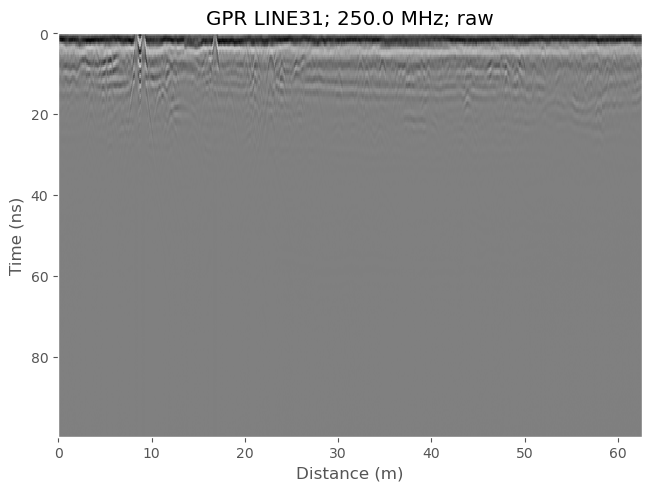

In [7]:
plot_gpr(data, addtitle='raw')

done with dewow


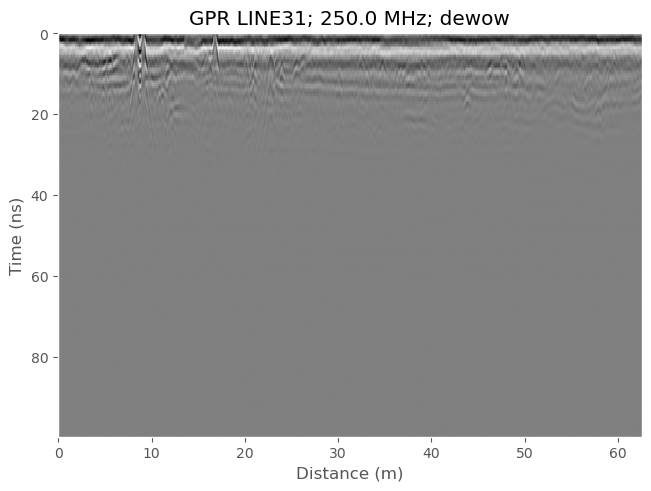

In [8]:
data_dewow = dewow(data, window=20)  # <= PLAY AROUND WITH WINDOW SIZE!
plot_gpr(data_dewow, 'dewow')

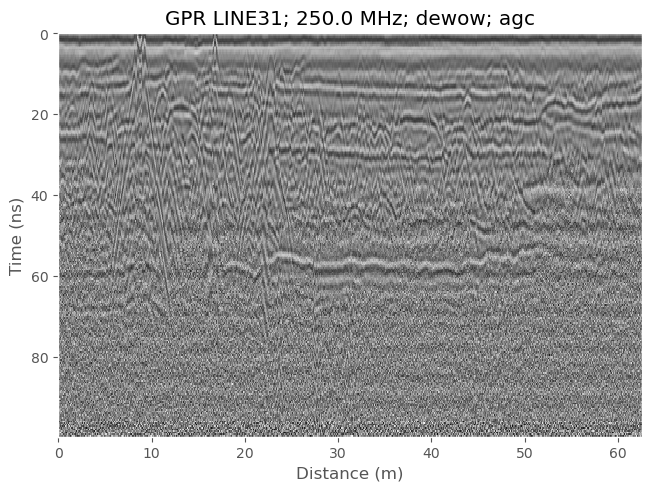

In [9]:
data_dewow_agc = agc_gain(data_dewow, window=20)  # <= PLAY AROUND WITH WINDOW SIZE!
plot_gpr(data_dewow_agc, 'dewow; agc')

In [10]:
try:
    from scooby import Report
except ImportError:
    class Report:
        def _repr_html_(self):
            return '`scooby` is not installed, not printing.'
Report()

--------------------------------------------------------------------------------
  Date: Thu Sep 12 12:05:57 2024 CEST

                OS : Linux (Ubuntu 22.04)
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
               RAM : 31.0 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC
  12.3.0]

             numpy : 1.26.4
             scipy : 1.14.0
           IPython : 8.26.0
        matplotlib : 3.9.0
            scooby : 0.10.0
--------------------------------------------------------------------------------